In [6]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import statsmodels
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.stats.outliers_influence import OLSInfluence

In [99]:
def univariate_analysis(series):
    print(series.describe())
    print("Outliers: " + str(len(outliers(series))))
    normality_test(series)
    print('\n')
    
def outliers(series):
    std = series.std()
    mean = series.mean()
    low = mean - (3*std)
    high = mean + (3*std)
    outliers = []
    for x in series:
        if x < low or x > high:
            outliers.append(x)
    return outliers  

def drop_outliers(df, col):
    std = df[col].std()
    mean = df[col].mean()
    low = mean - (3*std)
    high = mean + (3*std)
    for i, row in df.iterrows():
        if row[col] < low or row[col] > high:
            df.drop(i)
    return df
    

def univariate_plots(series, col):
    snan = series.dropna() 
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 2, 1)
    plt.hist(snan)
    plt.title(col + " Histogram")
    
    plt.subplot(1, 2, 2)
    plt.boxplot(snan)
    plt.title(col + " Box Plot")
    
def normality_test(series):
    snan = series.dropna()
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(snan)
    results = lzip(name, test)
    if results[1][1] < .05:
        normal = "No"
    else: 
        normal = "Yes"
    print("Normal?: " + normal)
    for result in results:
        print(result[0] + ": " + str(result[1]))

In [7]:
# R2: SSE/SSS is the portion of variation explained by the model

# Prob (F-statisic): If p-value < 0.05, we	can	reject the null	hypothesis.

# P >|t|: if p-value < 0.05, we can reject the null hypothesis: This variable does contribute to this model

# Prob(Omnibus): The p-value for this  test. If  p-value < 0.05, we  reject  the null  hypothesis: 
# ε does  not exactly follow  the normal  distribution that  we  assumed. 

# Prob(Omnibus):  The p-value for this  test.     

# Jaque Beara: Normality Test

# Prob(JB) Null  hypothesis:  ε is  normally  distributed. 

# Skewness and Kurtosis: Idea is we  are looking for a skewness coeff.  ~ 0,  and Kurtosis  ~ 3. JB  tests if  those conditions are held  against alternatives.  

# Condition Number: Note  that  is  the condi<on  number  becomes quite large,  then  this  implies that  the matrix  is  ill-posed   (does not have  a unique, well-defined  solution). This  may be  due to  multicollinear relationships  between independent variables.

In [8]:
# Load the data in
import pickle

with open("../data/processed/0202_all_data_wdummy.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 743
Data columns (total 21 columns):
energy_star_score                          390 non-null int64
building_floor_area                        390 non-null int64
parking_floor_area                         390 non-null int64
total_ghg_emissions                        390 non-null int64
site_eui                                   390 non-null int64
weather_normalized_site_eui                390 non-null int64
source_eui                                 390 non-null int64
weather_normalized_source_eui              390 non-null int64
water_use                                  390 non-null int64
property_id                                390 non-null int64
EMV_TOTAL                                  390 non-null float64
TAX_CAPAC                                  390 non-null float64
TOTAL_TAX                                  390 non-null float64
FIN_SQ_FT                                  390 non-null int64
YEAR_BUILT           

In [9]:
df.columns

Index(['energy_star_score', 'building_floor_area', 'parking_floor_area',
       'total_ghg_emissions', 'site_eui', 'weather_normalized_site_eui',
       'source_eui', 'weather_normalized_source_eui', 'water_use',
       'property_id', 'EMV_TOTAL', 'TAX_CAPAC', 'TOTAL_TAX', 'FIN_SQ_FT',
       'YEAR_BUILT', 'est_val_per_sqft', 'Intercept',
       'USE1_DESC[T.Condo Garage/Miscellaneous]', 'USE1_DESC[T.Cooperative]',
       'USE1_DESC[T.Industrial]', 'USE1_DESC[T.Other]'],
      dtype='object')

In [10]:
df['tax_per_sqft'] = df['TOTAL_TAX']/df['building_floor_area']
df['ghg_emissions_per_sqft'] = df['total_ghg_emissions']/df['building_floor_area']
df['year_built_adjusted'] = df['YEAR_BUILT'] - 1880
# df['emv_per_sqft'] = df['EMV_TOTAL']/df['FIN_SQ_FT']

In [11]:
df.head()

,energy_star_score,building_floor_area,parking_floor_area,total_ghg_emissions,site_eui,weather_normalized_site_eui,source_eui,weather_normalized_source_eui,water_use,property_id,...,YEAR_BUILT,est_val_per_sqft,Intercept,USE1_DESC[T.Condo Garage/Miscellaneous],USE1_DESC[T.Cooperative],USE1_DESC[T.Industrial],USE1_DESC[T.Other],tax_per_sqft,ghg_emissions_per_sqft,year_built_adjusted
0,36,62400,0,971,115,118,251,252,708,2302924430394,...,2012,162.099359,1.0,0.0,0.0,0.0,0.0,6.484135,0.015561,132
2,76,60640,62000,268,50,54,77,81,674,2202824340118,...,1959,0.362797,1.0,0.0,0.0,0.0,0.0,0.067167,0.004420,79
3,89,60528,0,504,74,77,136,140,414,2402924240052,...,1960,25.475813,1.0,0.0,1.0,0.0,0.0,0.265233,0.008327,80
4,89,60528,0,504,74,77,136,140,414,2402924240176,...,1962,0.916931,1.0,0.0,1.0,0.0,0.0,0.009549,0.008327,82
5,89,60528,0,504,74,77,136,140,414,2402924240177,...,1962,0.916931,1.0,0.0,1.0,0.0,0.0,0.009549,0.008327,82


In [91]:
subset = ['energy_star_score', 'building_floor_area', 'weather_normalized_site_eui',
       'weather_normalized_source_eui', 'water_use', 'EMV_TOTAL','year_built_adjusted',
       'est_val_per_sqft', 'tax_per_sqft', 'Intercept',
       'USE1_DESC[T.Condo Garage/Miscellaneous]', 'USE1_DESC[T.Cooperative]',
       'USE1_DESC[T.Industrial]', 'USE1_DESC[T.Other]']
subset_df = df[subset]

In [92]:
subset_df.head()

,energy_star_score,building_floor_area,weather_normalized_site_eui,weather_normalized_source_eui,water_use,EMV_TOTAL,year_built_adjusted,est_val_per_sqft,tax_per_sqft,Intercept,USE1_DESC[T.Condo Garage/Miscellaneous],USE1_DESC[T.Cooperative],USE1_DESC[T.Industrial],USE1_DESC[T.Other]
0,36,62400,118,252,708,10115000.0,132,162.099359,6.484135,1.0,0.0,0.0,0.0,0.0
2,76,60640,54,81,674,22000.0,79,0.362797,0.067167,1.0,0.0,0.0,0.0,0.0
3,89,60528,77,140,414,1542000.0,80,25.475813,0.265233,1.0,0.0,1.0,0.0,0.0
4,89,60528,77,140,414,55500.0,82,0.916931,0.009549,1.0,0.0,1.0,0.0,0.0
5,89,60528,77,140,414,55500.0,82,0.916931,0.009549,1.0,0.0,1.0,0.0,0.0


In [93]:
# Remove outliers
for col in subset_df.columns:
    subset_df = subset_df[np.abs(subset_df[col]-df[col].mean())<=(3*subset_df[col].std())]

In [94]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310 entries, 2 to 743
Data columns (total 14 columns):
energy_star_score                          310 non-null int64
building_floor_area                        310 non-null int64
weather_normalized_site_eui                310 non-null int64
weather_normalized_source_eui              310 non-null int64
water_use                                  310 non-null int64
EMV_TOTAL                                  310 non-null float64
year_built_adjusted                        310 non-null int64
est_val_per_sqft                           310 non-null float64
tax_per_sqft                               310 non-null float64
Intercept                                  310 non-null float64
USE1_DESC[T.Condo Garage/Miscellaneous]    310 non-null float64
USE1_DESC[T.Cooperative]                   310 non-null float64
USE1_DESC[T.Industrial]                    310 non-null float64
USE1_DESC[T.Other]                         310 non-null float64
dtypes: flo

In [95]:
# Remove NaN

subset_df = subset_df.dropna()

In [100]:
subset_df = drop_outliers(subset_df, 'EMV_TOTAL')

outliers(subset_df.EMV_TOTAL)

[30060000.0, 23000000.0, 40500000.0, 37670000.0, 24218000.0, 58330000.0]

In [84]:
# Define target and features variables

X = subset_df.ix[:,1:]
y = subset_df['energy_star_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4444)

In [46]:
# Fit regression model 

results = sm.OLS(y,X).fit()
# Inspect the results
results.summary()

/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_star_score   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     171.2
Date:                Mon, 20 Mar 2017   Prob (F-statistic):          1.32e-112
Time:                        11:31:59   Log-Likelihood:                -1259.0
No. Observations:                 310   AIC:                             2538.
Df Residuals:                     300   BIC:                             2575.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
building_floor_area                      8.273e-05   6.67e-06     12.406      0.000      6.96e-05  9.59e-05
weather_normalized_site_eui                 0.3513      0.065      5.412      0.000         0.224     0.479
weather_normalized_source_eui              -0.3998      0.029    -13.760      0.000        -0.457    -0.343
water_use                                  -0.0031      0.001     -6.130      0.000        -0.004    -0.002
EMV_TOTAL                               -6.178e-07   2.19e-07     -2.816      0.005     -1.05e-06 -1.86e-07
year_built_adjusted                         0.0540      0.031      1.734      0.084        -0.007     0.115
est_val_per_sqft                           -0.5234      0.337     -1.554      0.121        -1.186     0.139
tax_per_sqft                               20.9382      8.091      2.588      0.010         5.015    36.861
Intercept                                  93.7733      4.574     20.499      0.000        84.771   102.775
USE1_DESC[T.Condo Garage/Miscellaneous]    -2.5550      2.860     -0.893      0.372        -8.183     3.073
USE1_DESC[T.Cooperative]                         0          0        nan        nan             0         0
USE1_DESC[T.Industrial]                          0          0        nan        nan             0         0
USE1_DESC[T.Other]                               0          0        nan        nan             0         0
==============================================================================
Omnibus:                       75.488   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1086.130
Skew:                           0.506   Prob(JB):                    1.41e-236
Kurtosis:                      12.114   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

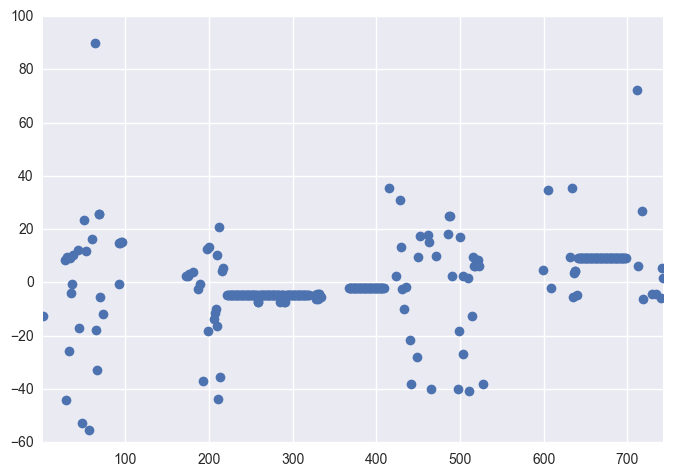

In [47]:
# Plot the residuals

results.resid.plot(style='o')

In [57]:
for col in subset_df.columns:
    univariate_analysis(subset_df[col])

count    310.000000
mean      59.438710
std       34.845212
min        2.000000
25%       16.000000
50%       78.000000
75%       89.000000
max      100.000000
Name: energy_star_score, dtype: float64
Outliers: 0
Normal?: No
Jarque-Bera: 45.170635934660844
Chi^2 two-tail prob.: 1.55353497396e-10
Skew: -0.3584948480591239
Kurtosis: 1.2728615378679273


count    3.100000e+02
mean     3.636784e+05
std      3.139653e+05
min      4.700000e+04
25%      1.738570e+05
50%      1.738570e+05
75%      4.445410e+05
max      1.235912e+06
Name: building_floor_area, dtype: float64
Outliers: 0
Normal?: No
Jarque-Bera: 74.16631980315486
Chi^2 two-tail prob.: 7.85214450096e-17
Skew: 1.1977747094106865
Kurtosis: 3.0570229068554817


count    310.000000
mean     111.019355
std       37.861948
min        0.000000
25%       74.250000
50%      112.000000
75%      149.000000
max      209.000000
Name: weather_normalized_site_eui, dtype: float64
Outliers: 0
Normal?: No
Jarque-Bera: 11.230695851096149
Chi^2 two-ta

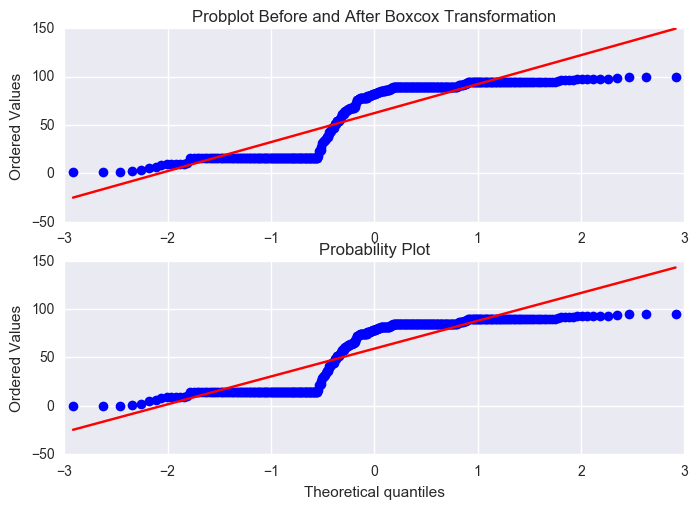

In [85]:
# Attempted a Boxcox transformation?

fig = plt.figure()
ax1 = fig.add_subplot(211)
x = df['energy_star_score']
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot Before and After Boxcox Transformation')

ax2 = fig.add_subplot(212)
xt, _ = stats.boxcox(x)
prob2 = stats.probplot(xt, dist=stats.norm, plot=ax2)

plt.show()

In [ ]:
def variable_diagnostics(var):
    # Normality of the residuals, Jarque-Bera test
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(results.resid)
    lzip(name, test)
    
    # Influence
    test_class = OLSInfluence(results)
    test_class.dfbetas[:5,:]
    
    # Multicolinearity, conditional number
    np.linalg.cond(results.model.exog)
    
    # Heteroskedasticity, Breush-Pagan test:    
    name = ['Lagrange multiplier statistic', 'p-value', 
            'f-value', 'f p-value']
    test = sms.het_breushpagan(results.resid, results.model.exog)
    lzip(name, test)
    
    # Linearity, 
    name = ['t value', 'p value']
    test = sms.linear_harvey_collier(results)
    lzip(name, test)

In [ ]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    
    plt.subplot(1, 3, 3)
    z = (res-np.mean(res))/np.std(res)
    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [87]:
# Normality of the residuals, Jarque-Bera test
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)

[('Jarque-Bera', 971.6378789132256),
 ('Chi^2 two-tail prob.', 1.0268698197588122e-211),
 ('Skew', 0.5612759634012321),
 ('Kurtosis', 11.475916445889817)]

In [33]:
# Influence
test_class = OLSInfluence(results)
test_class.dfbetas[:5,:]

array([[  2.84559716e-02,  -4.35095860e-02,   9.62039190e-02,
          4.81928515e-02,   2.77402290e-01,   3.27692382e-02,
         -1.05068823e-01,   3.83191906e-02,  -3.05637463e-02,
         -1.14281756e-01,  -2.83588984e-02,  -1.23597917e-02,
          1.64507171e-03],
       [  4.23799834e-03,  -1.16026196e-03,   1.04600156e-02,
          2.03217690e-03,  -2.90714116e-03,  -5.43034666e-03,
          1.52776699e-03,  -4.09213422e-04,  -7.09695552e-03,
          8.71906248e-03,   1.16350764e-02,   2.55393555e-03,
          4.33905854e-03],
       [ -1.01936185e-02,   1.35401324e-02,   1.04949457e-04,
         -6.43936101e-03,  -5.74687145e-04,  -9.81639901e-04,
          1.02617068e-01,  -1.01112672e-01,   3.85695326e-03,
         -1.21036375e-02,   5.33074802e-02,  -2.47862555e-03,
         -3.09340264e-02],
       [ -2.17393177e-05,   2.88788215e-05,   2.28191033e-07,
         -1.37355496e-05,  -1.22405229e-06,  -2.06019154e-06,
          2.18895365e-04,  -2.15687861e-04,   8.199

In [34]:
# Multicolinearity, conditional number
np.linalg.cond(results.model.exog)

221551362.98178157

In [35]:
# Heteroskedasticity, Breush-Pagan test:
name = ['Lagrange multiplier statistic', 'p-value', 
            'f-value', 'f p-value']
test = sms.het_breushpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 134.85164376388929),
 ('p-value', 6.5344797494973697e-23),
 ('f-value', 16.604414796471222),
 ('f p-value', 2.0526878390211342e-28)]

In [68]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)

LinAlgError: Singular matrix

In [53]:
with open('../data/processed/0202_all_data_transf.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

In [ ]:
# Univariate regression analysis

import statsmodels.api as sm
import pandas as pd
import numpy as np

df = pd.DataFrame({
  'y': np.random.randn(20),
  'x1': np.random.randn(20), 
  'x2': np.random.randn(20),
  'grp': ['a', 'b'] * 10})

def ols_res(x, y):
    return pd.Series(sm.OLS(y, x).fit().predict())

df.groupby('grp').apply(lambda x : x[['x1', 'x2']].apply(ols_res, y=x['y']))

In [67]:
df['energy_star_score'].describe()

count    390.000000
mean      62.223077
std       33.755266
min        1.000000
25%       16.000000
50%       82.000000
75%       89.000000
max      100.000000
Name: energy_star_score, dtype: float64

In [106]:
def univariate_analysis(series):
    print(series.describe())
    print("Outliers: " + str(len(outliers(series))))
    print("Normal?: ")
    univariate_plots(series)
    
def outliers(series):
    std = series.std()
    mean = series.mean()
    low = mean - (3*std)
    high = mean + (3*std)
    outliers = []
    for x in series:
        if x < low or x > high:
            outliers.append(x)
    return outliers

def univariate_plots(series):
    plt.figure(figsize=(20,5))
    
    plt.subplot(1, 2, 1)
    plt.hist(series)
    plt.title("Histogram")
    
    plt.subplot(1, 2, 2)
    plt.boxplot(series)
    plt.title("Box Plot")
    

count    390.000000
mean      62.223077
std       33.755266
min        1.000000
25%       16.000000
50%       82.000000
75%       89.000000
max      100.000000
Name: energy_star_score, dtype: float64
Outliers: 0


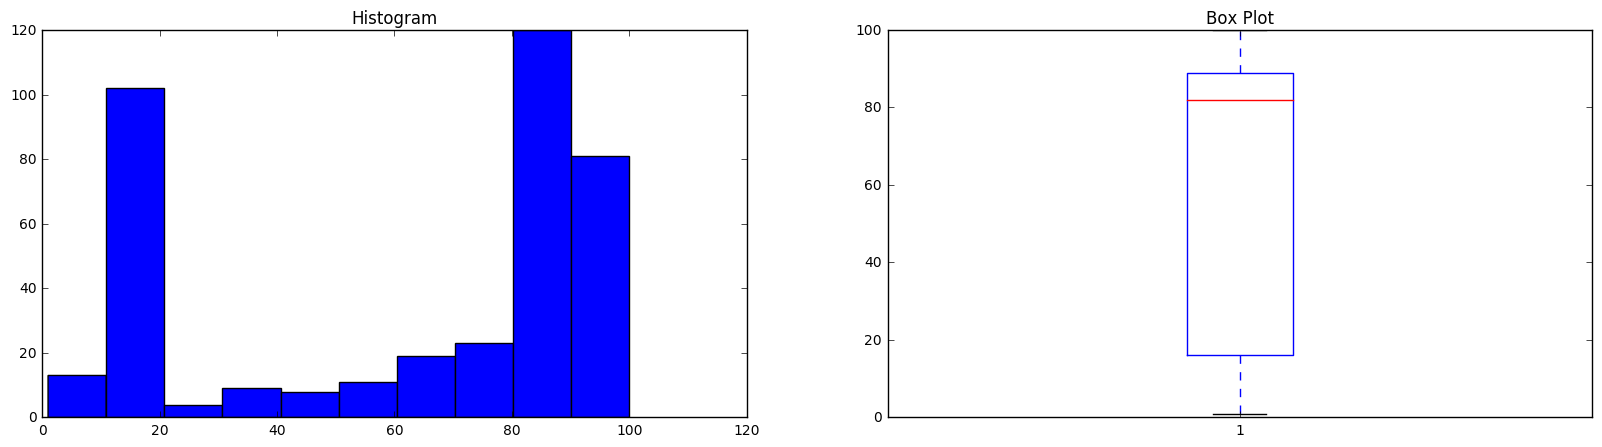

In [107]:
univariate_analysis(df['energy_star_score'])

In [108]:
from scipy.stats import pearsonr
pearsonr(df[['energy_star_score']], )

TypeError: pearsonr() missing 1 required positional argument: 'y'

## Lasso Regularization

In [21]:
from sklearn import linear_model, preprocessing

# Standardize X
X_scaled = preprocessing.scale(X)

# Create LassoCV object; set seed for reproducibility
lasso_cv = linear_model.LassoCV(cv=5, normalize=False, verbose=True, random_state=42)

# Create model
lasso_cv.fit(X_scaled, y)

........................................................................................................................................................................................................................................................................................................................................................................................................../Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
..........................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=42, selection='cyclic', tol=0.0001,
    verbose=True)

In [22]:
# Output coefficients of best model 
lasso_cv.coef_

array([ 24.81970155,  10.70087574, -29.43672455,  -9.95472227,
        -2.81844499,   2.17837622,  -6.33178024,  13.09771025,
         0.        ,  -1.71388459,   0.        ,   0.        ,   0.        ])

## Ridge Regularization

In [23]:
# Ridge regularization

from sklearn.linear_model import RidgeCV

# Create LassoCV object; set seed for reproducibility
ridge_cv = RidgeCV(cv=5)

# Create model
ridge_cv.fit(X_scaled, y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

## Plots

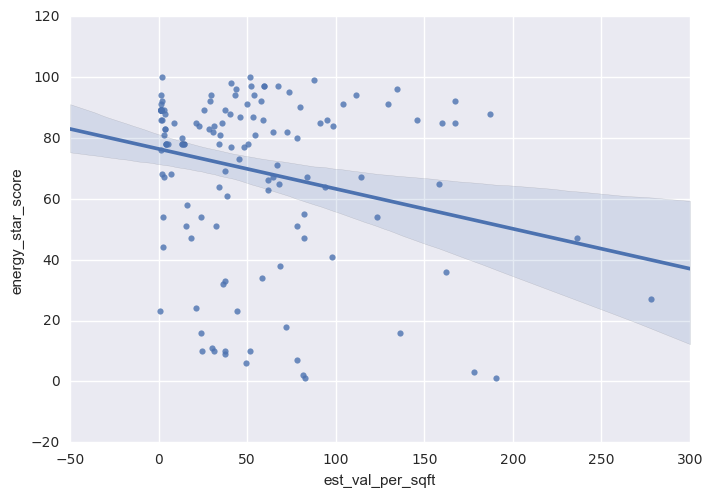

In [58]:
df2 = df[df['est_val_per_sqft'] > 1]
# Reg Plots 
ax = sns.regplot(x="est_val_per_sqft", y="energy_star_score", data=df2)